In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

c:\Users\Sam\miniconda3\envs\wisp\lib\site-packages\tqdm-4.64.1-py3.9.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
points= torch.tensor([
[0, 0, 0],
[0, 0, 1],
[0, 0, 2],
[0, 0, 3],
[0, 1, 0]], device='cpu', dtype=torch.int16)
points

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 1, 0]], dtype=torch.int16)

In [4]:
levels=6

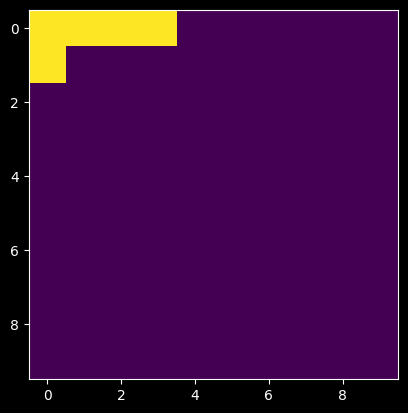

In [5]:
p=np.zeros((2**levels,2**levels,2**levels))
p[points[:,0],points[:,1],points[:,2]]=1
plt.imshow(p[0,:10,:10])

In [6]:
pts=np.array(torch.unique(points,dim=0), dtype=np.uint8)[:,None]
bits = np.unpackbits(pts, 1)[...,[2,1,1]]
bits=bits.reshape(len(bits),-1)
bits.shape

(5, 24)

In [7]:
m_idx=bits@np.power(2,np.arange(24)[ : :-1])
m_idx

array([ 0,  4, 32, 36,  3], dtype=int32)

In [8]:
oct=np.zeros((2**levels)**3, dtype=bool)
oct

array([False, False, False, ..., False, False, False])

In [9]:
oct[m_idx]=1
oct

array([ True, False, False, ..., False, False, False])

In [10]:
octree=[]

In [11]:
oct.shape

(262144,)

In [12]:
for l in range(levels):
    octL = np.packbits(oct.reshape(-1,8),-1)
    oct = octL>0
    octree.insert(0,octL[oct])

In [13]:
for i in range(levels):
    print(octree[i])
    print(np.unpackbits(octree[i]))

[128]
[1 0 0 0 0 0 0 0]
[128]
[1 0 0 0 0 0 0 0]
[128]
[1 0 0 0 0 0 0 0]
[128]
[1 0 0 0 0 0 0 0]
[136]
[1 0 0 0 1 0 0 0]
[152 136]
[1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0]


In [14]:
np.concatenate(octree)

array([128, 128, 128, 128, 136, 152, 136], dtype=uint8)

In [15]:
level=6
t=0
for i in range(level):
    t+=(2**i)**3

In [16]:
t

37449

In [17]:
import wisp.ops.spc as wisp_spc_ops

In [66]:
import numpy as np
def quantized_to_octree(quantized_points, level):

    if quantized_points.device!='cpu':
        quantized_points=quantized_points.detach().cpu()

    pts=np.array(torch.unique(quantized_points,dim=0), dtype=np.uint8)[:,None]
    bits = np.unpackbits(pts, 1)[...,[0,1,2]]
    bits = bits.reshape(len(bits),-1)

    m_idx=bits@np.power(2,np.arange(24)[ : :-1])

    oct=np.zeros((2**level)**3, dtype=bool)
    oct[m_idx]=1
    octree=[]

    for _ in range(level):
        octL = np.packbits(oct.reshape(-1,8),-1,bitorder='little')
        oct = octL>0
        octree.insert(0,octL[oct])

    return torch.tensor(np.concatenate(octree), dtype=torch.uint8, device='cuda')

In [70]:
points

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 1, 0]], dtype=torch.int16)

In [67]:
octree = quantized_to_octree(points, level)
points1, pyramid, prefix = wisp_spc_ops.octree_to_spc(octree)
octree, points1, pyramid, prefix

(tensor([1, 1, 1, 1, 3, 7, 3], device='cuda:0', dtype=torch.uint8),
 tensor([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 1],
         [0, 0, 0],
         [0, 0, 1],
         [0, 1, 0],
         [0, 0, 2],
         [0, 0, 3]], device='cuda:0', dtype=torch.int16),
 tensor([[ 1,  1,  1,  1,  1,  2,  5,  0],
         [ 0,  1,  2,  3,  4,  5,  7, 12]], dtype=torch.int32),
 tensor([ 0,  1,  2,  3,  4,  6,  9, 11], device='cuda:0', dtype=torch.int32))

In [68]:
points1, pyramid, prefix = wisp_spc_ops.octree_to_spc(torch.tensor([4],dtype=torch.uint8, device='cuda'))
octree, points1, pyramid, prefix

(tensor([1, 1, 1, 1, 3, 7, 3], device='cuda:0', dtype=torch.uint8),
 tensor([[0, 0, 0],
         [0, 1, 0]], device='cuda:0', dtype=torch.int16),
 tensor([[1, 1, 0],
         [0, 1, 2]], dtype=torch.int32),
 tensor([0, 1], device='cuda:0', dtype=torch.int32))

In [69]:
quantized_to_octree(torch.tensor([[0,1,0]]), 1)

tensor([4], device='cuda:0', dtype=torch.uint8)